<a href="https://colab.research.google.com/github/afortuny/StableDifusion/blob/main/Stable_Diffusion_Deep_Dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion with ðŸ¤— Diffusers

Chances are you'll have seen examples in Twitter (and elsewhere) of images generated by typing a short description of the scene you want to create. This is the culmination of years of work in generative models. This notebook introduces Stable Diffusion, the highest-quality open source text to image model as of now. It's also small enough to run in consumer GPUs rather than in a datacenter. We use the ðŸ¤— Hugging Face ðŸ§¨ Diffusers library, which is currently our recommended library for using diffusion models.

As we'll see during the course, understanding state-of-the-art generative models requires a deep understanding of many of the fundamental blocks in modern machine learning models. This notebook shows what Stable Diffusion can do and a glimpse of its main components.

In [2]:
!pip install -Uq diffusers transformers fastcore

     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 524 kB 4.7 MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 5.8 MB 51.6 MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 182 kB 67.8 MB/s 
     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 7.6 MB 56.0 MB/s 


In [4]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


# Using Stable Diffusion

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The model card provides more details. If you do accept the license, you need to be a registered user in ðŸ¤— Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

Use the huggingface-cli login command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
Or use notebook_login() in a notebook, which does the same thing.

In [5]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

StableDiffusionPipeline is an end-to-end diffusion inference pipeline that allows you to start generating images with just a few lines of code. Many Hugging Face libraries (along with other libraries such as scikit-learn) use the concept of a "pipeline" to indicate a sequence of steps that when combined complete some task. We'll look at the individual steps of the pipeline later -- for now though, let's just use it to see what it can do.

When we say "inference" we're referring to using an existing model to generate samples (in this case, images), as opposed to "training" (or fine-tuning) models using new data.

We use from_pretrained to create the pipeline and download the pretrained weights. We indicate that we want to use the fp16 (half-precision) version of the weights, and we tell diffusers to expect the weights in that format. This allows us to perform much faster inference with almost no discernible difference in quality. The string passed to from_pretrained in this case (CompVis/stable-diffusion-v1-4) is the repo id of a pretrained pipeline hosted on Hugging Face Hub; it can also be a path to a directory containing pipeline weights. The weights for all the models in the pipeline will be downloaded and cached the first time you run this cell.

In [6]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16).to("cuda")

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

The weights are cached in your home directory by default.

In [7]:
!ls ~/.cache/huggingface/diffusers/

models--CompVis--stable-diffusion-v1-4


In [8]:
pipe.enable_attention_slicing()

In [11]:
prompt = "a photograph of the sea flooding mediterranean houses"

  0%|          | 0/50 [00:00<?, ?it/s]

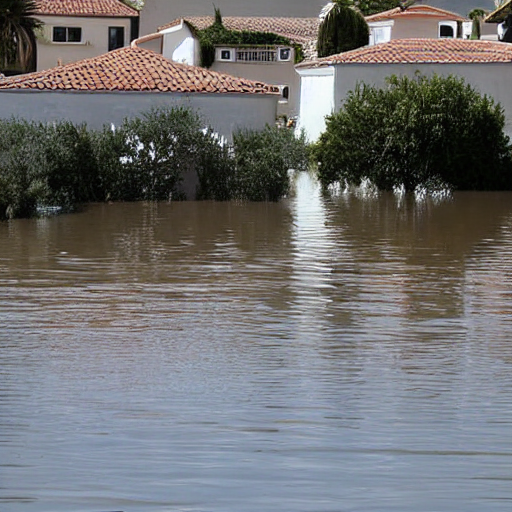

In [12]:
pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

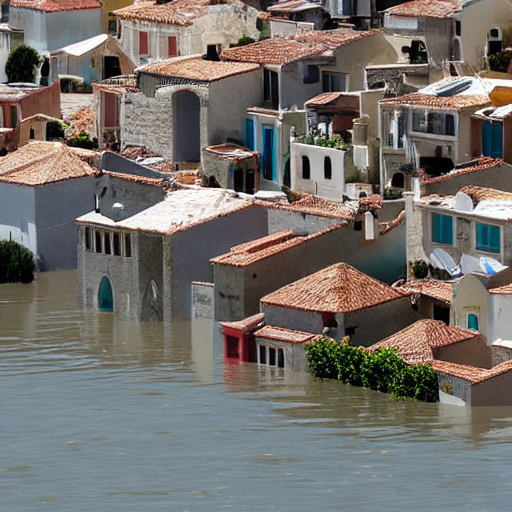

In [13]:
torch.manual_seed(1024)
pipe(prompt).images[0]

You will have noticed that running the pipeline shows a progress bar with a certain number of steps. This is because Stable Diffusion is based on a progressive denoising algorithm that is able to create a convincing image starting from pure random noise. Models in this family are known as diffusion models. 

  0%|          | 0/3 [00:00<?, ?it/s]

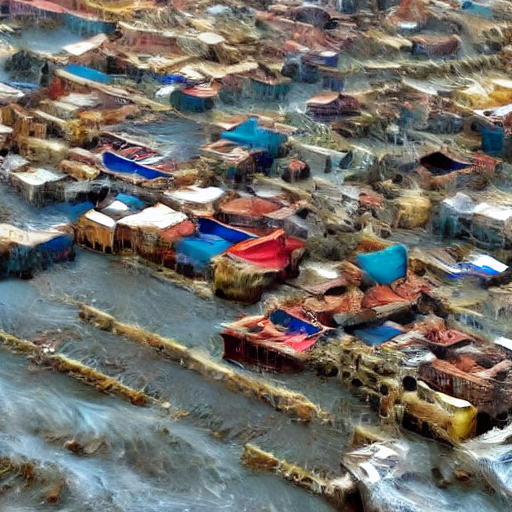

In [14]:
torch.manual_seed(1024)
pipe(prompt, num_inference_steps=3).images[0]